# This notebook presents a Brain tumor segmentation using YOLOV8

In [ ]:
!pip install ultralytics
!pip install pillow


# Load the data from RoboFlow


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="OnGlMCYxYZ8dDgjdDCKf")
project = rf.workspace("ons").project("brain-fkcpf")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to Brain-1 in yolov8:: 100%|██████████| 90/90 [00:00<00:00, 4841.32it/s]


In [ ]:
import locale
from zipfile import ZipFile
import os
# The data directory is currently hard-coded, if you want to train in different location you need to change it:
#C:\Users\name\AppData\Roaming\Ultralytics\settings.yaml
# then you need to re-import it
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
import torch
import numpy as np
from PIL import Image  # to display images
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from IPython import display
display.clear_output()
from IPython.display import Image
import shutil
import glob
import torch
from IPython.display import Image, display
from PIL import Image
from PIL import ImageDraw
print(f"Setup complete. Using torch {torch.__version__} on device ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.1.0+cu118 on device (Tesla T4)


In [ ]:
!nvidia-smi

Sun Nov 19 14:28:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Test the YoloV8prediction


In this step we will test our pre-trained YoloV8 before the fine-Tuning

In [ ]:
#Load the Pre-Trained model Yolo for segmentation
model= YOLO("yolov8s-seg.pt")

In [ ]:
#Display the architecture model
model


YOLO(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_runnin


image 1/1 /content/Brain-1/train/images/Tr-me_0010_jpg.rf.e0922014c8381cebf323a5e5a537fe68.jpg: 640x640 1 clock, 34.7ms
Speed: 4.5ms preprocess, 34.7ms inference, 50.6ms postprocess per image at shape (1, 3, 640, 640)


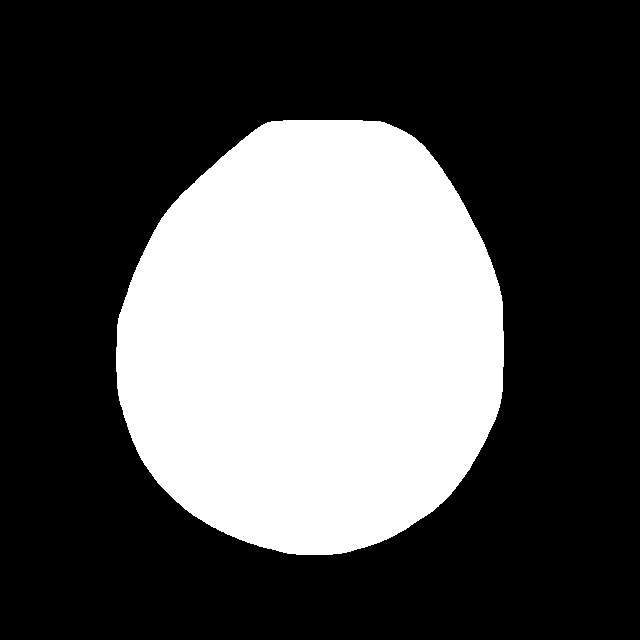

In [ ]:

results = model.predict("/content/Brain-1/train/images/Tr-me_0010_jpg.rf.e0922014c8381cebf323a5e5a537fe68.jpg")
result = results[0]
masks = result.masks
mask1 = masks[0]
# Assuming mask1 is the PyTorch tensor you want to convert
mask1_cpu = mask1.cpu().data[0].numpy()
polygon = mask1.xy[0]
mask_img = Image.fromarray(mask1_cpu, "I")
mask_img

#Based on the pre-trained model's prediction results, YOLOv8 was unable to segment the tumor and instead segmented the entire brain. Fine-tuning the pre-trained model is necessary to accurately segment the tumor.

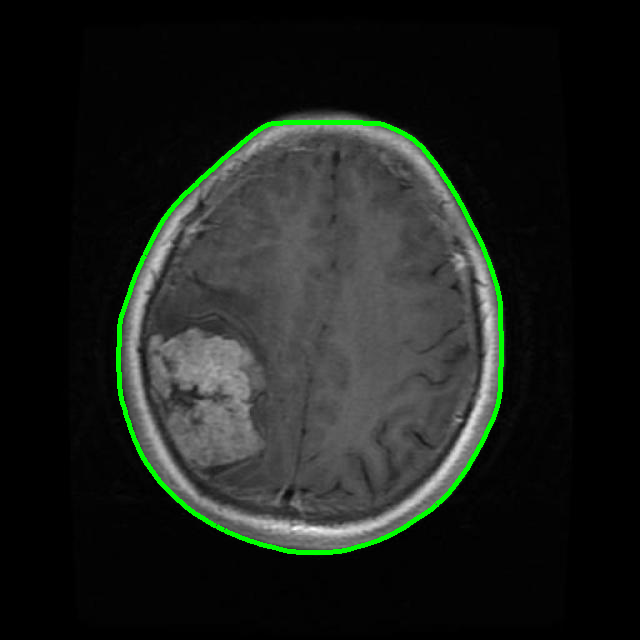

In [ ]:

img = Image.open("/content/Brain-1/valid/images/Tr-me_0010_jpg.rf.e0922014c8381cebf323a5e5a537fe68.jpg")
draw = ImageDraw.Draw(img)
draw.polygon(polygon,outline=(0,255,0), width=5)
img

# fine Tuning the YoloV8

To fine-tuning the YOLOV8 model, we simply train the pre-trained model 'yolov8n-seg.pt' on the data.yaml file. This file includes the directory of images for both training and validation sets, the name of the class (which is 'tumor' in our case), and the number of classes (which is 1). explain this p^rocess more

In [ ]:
#Load the Pre-Trained model Yolo for segmentation
model= YOLO('yolov8n-seg.pt')
results = model.train(
    data='/content/Brain-1/data.yaml',
    batch=5,
    save_json=True,
    epochs=50,
    pretrained=True
)


Ultralytics YOLOv8.0.212 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/Brain-1/data.yaml, epochs=50, patience=50, batch=5, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=True, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, 

train: Scanning /content/Brain-1/train/labels... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<00:00, 594.37it/s]

train: New cache created: /content/Brain-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Brain-1/valid/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 279.00it/s]

val: New cache created: /content/Brain-1/valid/labels.cache


Plotting labels to runs/segment/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005078125), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.14G      1.533      3.282      4.493        1.5          1        640: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.36s/it]

                   all         10         10    0.00267        0.8    0.00338     0.0018      0.003        0.9    0.00466    0.00197



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.03G      1.405      3.271      4.272      1.341          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.23s/it]

                   all         10         10      0.003        0.9    0.00467     0.0024      0.003        0.9    0.00467    0.00229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.04G      1.011      2.013      4.568      1.092          0        640: 100%|██████████| 7/7 [00:01<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.04s/it]

                   all         10         10    0.00333          1     0.0291     0.0055    0.00333          1     0.0289    0.00794



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.18G      1.233      1.975      3.299       1.19          1        640: 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.01s/it]

                   all         10         10    0.00333          1     0.0234     0.0102    0.00333          1     0.0229    0.00679



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.04G      1.124      1.931      2.524      1.172          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.40s/it]

                   all         10         10    0.00333          1      0.276      0.106    0.00267        0.8      0.275      0.126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.06G      1.158      2.014      2.356      1.126          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.56s/it]

                   all         10         10    0.00267        0.8      0.321       0.18      0.003        0.9      0.319      0.174



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.18G      1.248      1.973      2.625      1.273          1        640: 100%|██████████| 7/7 [00:01<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.42s/it]

                   all         10         10    0.00333          1      0.274      0.163      0.003        0.9      0.273      0.146



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.05G      1.178      1.733      2.716      1.185          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.80s/it]

                   all         10         10    0.00474        0.8      0.306      0.123    0.00474        0.8      0.306      0.139



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.04G      1.095      1.528      2.318      1.106          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.62s/it]

                   all         10         10    0.00333          1      0.686      0.481      0.003        0.9      0.686       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.06G      1.448      2.058      2.841      1.311          1        640: 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.41s/it]

                   all         10         10    0.00333          1      0.686      0.481      0.003        0.9      0.686       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.18G      1.581      2.615      2.715      1.444          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.82s/it]

                   all         10         10      0.003        0.9      0.204      0.113      0.003        0.9      0.196     0.0898



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.18G      1.629      2.994      3.327      1.464          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.92s/it]

                   all         10         10    0.00362        0.5      0.364      0.129    0.00507        0.7       0.39       0.25



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.06G      1.324      1.947      2.729      1.314          1        640: 100%|██████████| 7/7 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.51s/it]

                   all         10         10    0.00362        0.5      0.364      0.129    0.00507        0.7       0.39       0.25



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.18G      1.287      1.908      3.061      1.234          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.86s/it]

                   all         10         10      0.404        0.2      0.144     0.0793      0.404        0.2      0.185     0.0903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.17G      1.411      2.238       2.64      1.282          3        640: 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.14s/it]

                   all         10         10      0.404        0.2      0.144     0.0793      0.404        0.2      0.185     0.0903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50       1.2G      1.318       1.88      2.172      1.301          2        640: 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.71s/it]

                   all         10         10      0.366        0.3      0.298      0.188      0.366        0.3      0.304      0.154



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.04G      1.321      1.944      2.367      1.246          2        640: 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.65s/it]

                   all         10         10      0.827       0.48      0.562      0.372      0.827       0.48      0.546      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.07G      1.319      1.966      2.127      1.271          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.64s/it]

                   all         10         10      0.827       0.48      0.562      0.372      0.827       0.48      0.546      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.06G      1.193      1.597      2.049      1.176          1        640: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.88s/it]

                   all         10         10      0.961        0.6       0.74      0.418      0.961        0.6      0.722      0.484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.17G      1.825      1.926      3.742      1.573          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.85s/it]

                   all         10         10      0.961        0.6       0.74      0.418      0.961        0.6      0.722      0.484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.18G      1.371      1.639      2.231      1.295          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.18s/it]

                   all         10         10      0.967        0.8      0.922      0.614      0.967        0.8      0.885      0.567



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.17G       1.22      1.917      2.184      1.264          3        640: 100%|██████████| 7/7 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.55s/it]

                   all         10         10      0.967        0.8      0.922      0.614      0.967        0.8      0.885      0.567



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.18G      1.331      2.069      2.313      1.428          3        640: 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.99s/it]

                   all         10         10      0.723      0.785      0.815      0.589      0.723      0.785      0.771      0.566



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50       1.2G      1.262      1.644      2.092      1.219          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.82s/it]

                   all         10         10      0.723      0.785      0.815      0.589      0.723      0.785      0.771      0.566



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.06G      1.467      2.121      2.258      1.421          1        640: 100%|██████████| 7/7 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.76s/it]

                   all         10         10      0.716      0.759      0.787      0.524      0.716      0.759        0.8      0.568



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.06G      1.309      1.701      2.079      1.203          2        640: 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.16s/it]

                   all         10         10      0.716      0.759      0.787      0.524      0.716      0.759        0.8      0.568



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.18G      1.358      2.171      2.097       1.35          2        640: 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.81s/it]

                   all         10         10      0.883        0.9      0.922      0.564      0.883        0.9      0.903      0.582



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.18G       1.36      2.337      2.252      1.435          2        640: 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.75s/it]

                   all         10         10      0.883        0.9      0.922      0.564      0.883        0.9      0.903      0.582



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50       1.2G      1.373      1.942      2.124      1.327          4        640: 100%|██████████| 7/7 [00:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.80s/it]

                   all         10         10          1      0.675       0.87      0.535          1      0.675      0.853      0.524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.17G      1.037      1.794      2.754      1.012          0        640: 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00, 10.00s/it]

                   all         10         10          1      0.772      0.883       0.61          1      0.772      0.883      0.614



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50       1.2G      1.286      2.191      2.255      1.271          2        640: 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.09s/it]

                   all         10         10          1      0.772      0.883       0.61          1      0.772      0.883      0.614



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.07G      1.223      1.856      2.144      1.234          2        640: 100%|██████████| 7/7 [00:01<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.04s/it]

                   all         10         10      0.978        0.9      0.935      0.664      0.978        0.9      0.935      0.656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.04G      1.135      1.799      1.907      1.153          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.88s/it]

                   all         10         10      0.978        0.9      0.935      0.664      0.978        0.9      0.935      0.656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.17G      1.229      1.669      2.433      1.333          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.59s/it]

                   all         10         10      0.993        0.9      0.948        0.7      0.993        0.9      0.948      0.718



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.17G      1.153      1.491       2.12      1.149          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.66s/it]

                   all         10         10      0.993        0.9      0.948        0.7      0.993        0.9      0.948      0.718



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.05G       1.01      1.464       1.48       1.09          2        640: 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.37s/it]

                   all         10         10       0.99        0.9      0.954      0.702       0.99        0.9      0.954      0.712



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.04G      1.086      1.455       1.61       1.17          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.44s/it]

                   all         10         10       0.99        0.9      0.954      0.702       0.99        0.9      0.954      0.712



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.06G      1.427      2.504      2.596       1.21          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.58s/it]

                   all         10         10      0.883        0.9      0.946      0.679      0.883        0.9      0.946      0.714



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.06G      1.179      1.467      1.799      1.253          1        640: 100%|██████████| 7/7 [00:01<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.81s/it]

                   all         10         10      0.883        0.9      0.946      0.679      0.883        0.9      0.946      0.714



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.17G      1.173      1.532       1.71      1.166          2        640: 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.42s/it]

                   all         10         10          1      0.889      0.966      0.654          1      0.889      0.966      0.732


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.18G      1.103      1.402      1.851       1.22          1        640: 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.35s/it]

                   all         10         10          1      0.889      0.966      0.654          1      0.889      0.966      0.732



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.05G       1.06      1.397      1.965      1.215          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.27s/it]

                   all         10         10          1      0.891      0.962      0.658          1      0.891      0.962      0.742



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.05G     0.8733      1.335      1.848      1.154          1        640: 100%|██████████| 7/7 [00:01<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.07s/it]

                   all         10         10      0.993        0.9      0.951      0.668      0.993        0.9      0.951      0.732



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.05G      1.072      1.603      1.818      1.202          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.32s/it]

                   all         10         10      0.993        0.9      0.951      0.668      0.993        0.9      0.951      0.732



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.05G     0.9212      1.309      1.633      1.147          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.49s/it]

                   all         10         10      0.991        0.9       0.94        0.7      0.991        0.9       0.94      0.723



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.05G      1.003      1.378      1.632      1.164          1        640: 100%|██████████| 7/7 [00:01<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.85s/it]

                   all         10         10      0.991        0.9       0.94        0.7      0.991        0.9       0.94      0.723



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.05G     0.8995      1.345      1.757      1.055          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.52s/it]

                   all         10         10      0.986        0.9      0.931      0.703      0.986        0.9      0.931      0.707



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.05G     0.8486      1.267      1.654      1.057          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.76s/it]

                   all         10         10      0.986        0.9      0.931      0.703      0.986        0.9      0.931      0.707



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.05G     0.9166      1.218      1.667      1.132          1        640: 100%|██████████| 7/7 [00:01<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.67s/it]

                   all         10         10      0.986        0.9      0.926      0.701      0.986        0.9      0.926      0.715



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.05G     0.8456      1.231      1.707      1.164          1        640: 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.45s/it]

                   all         10         10      0.986        0.9      0.926      0.701      0.986        0.9      0.926      0.715



50 epochs completed in 0.156 hours.
Optimizer stripped from runs/segment/train3/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train3/weights/best.pt, 6.8MB

Validating runs/segment/train3/weights/best.pt...
Ultralytics YOLOv8.0.212 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.16s/it]


                   all         10         10      0.991        0.9       0.94        0.7      0.991        0.9       0.94      0.723
Speed: 1.1ms preprocess, 3.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Saving runs/segment/train3/predictions.json...
Results saved to runs/segment/train3


In [ ]:
#!yolo task=segment mode=val model=/content/drive/MyDrive/Segmentation/best.pt data=/content/Brain-1/data.yaml

#Plotting the different losses

In [ ]:
df=pd.read_csv('/content/runs/segment/train3/results.csv')

In [ ]:
df.head()

,epoch,train/box_loss,train/seg_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/precision(M),metrics/recall(M),metrics/mAP50(M),metrics/mAP50-95(M),val/box_loss,val/seg_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.5328,3.2816,4.4934,1.4997,0.00267,0.8,0.00338,0.00180,0.00300,0.9,0.00466,0.00197,0.98593,2.3204,4.3481,1.3751,0.000120,0.000120,0.000120
1,2,1.4045,3.2710,4.2717,1.3413,0.00300,0.9,0.00467,0.00240,0.00300,0.9,0.00467,0.00229,1.00220,2.3520,4.3529,1.3535,0.000255,0.000255,0.000255
2,3,1.0106,2.0127,4.5682,1.0924,0.00333,1.0,0.02914,0.00550,0.00333,1.0,0.02887,0.00794,1.16190,2.2425,4.2291,1.2716,0.000384,0.000384,0.000384
3,4,1.2330,1.9750,3.2990,1.1905,0.00333,1.0,0.02337,0.01018,0.00333,1.0,0.02294,0.00679,1.22660,2.3622,4.2835,1.3354,0.000508,0.000508,0.000508
4,5,1.1245,1.9309,2.5241,1.1717,0.00333,1.0,0.27608,0.10612,0.00267,0.8,0.27546,0.12599,1.41790,2.2142,4.3980,1.5509,0.000626,0.000626,0.000626


In [ ]:
df.columns


During the training of your YOLOv8 model, it is a good sign if you notice a consistent decrease in the loss values of all three components - classifier, bounding box regression, and segmentation. When the loss values decrease, it means that your model is learning and improving its ability to predict accurately on both the training and validation sets. So, decreasing loss values is a positive indicator of your model's performance.

# Classifier Loss

```
# `Ce texte est au format code`
```



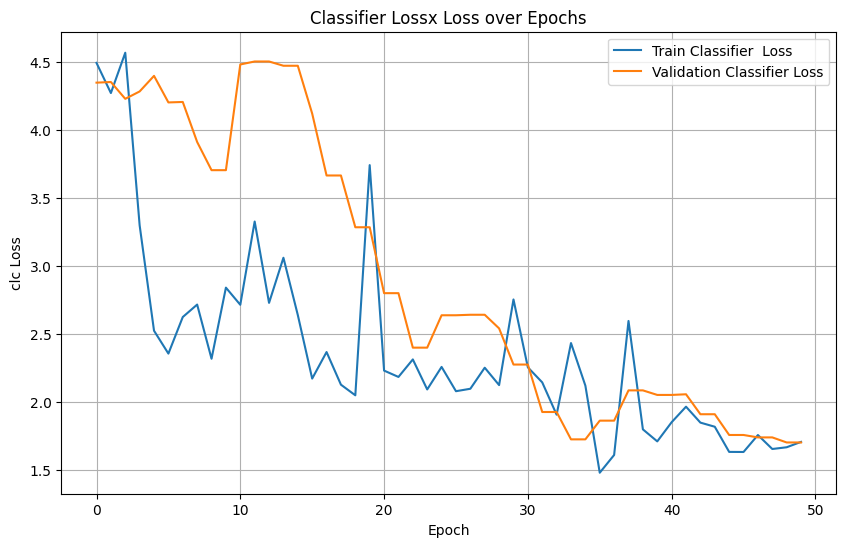

In [ ]:
# Plotting the box loss
plt.figure(figsize=(10, 6))
plt.plot( df['train/cls_loss'], label='Train Classifier  Loss')
plt.plot( df['val/cls_loss'], label='Validation Classifier Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('clc Loss')
plt.title('Classifier Lossx Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Bounding Box regression Loss


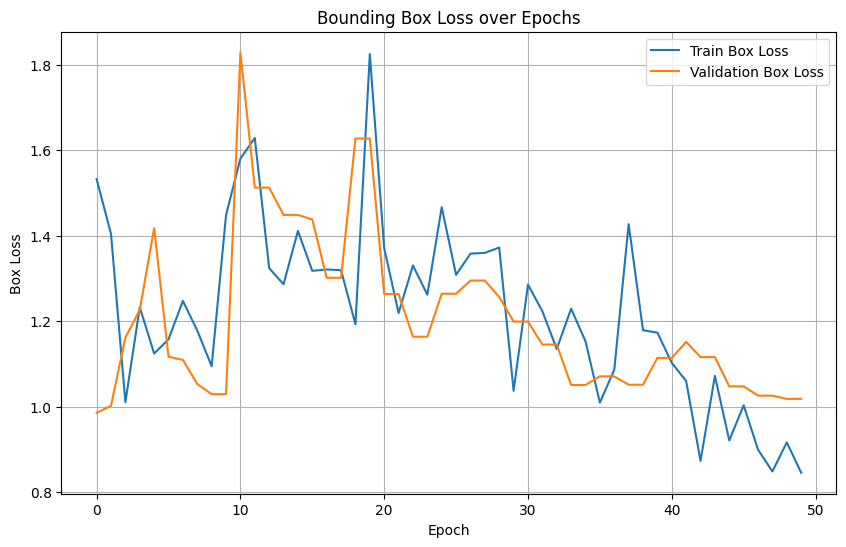

In [ ]:
# Plotting the box loss
plt.figure(figsize=(10, 6))
plt.plot( df['train/box_loss'], label='Train Box Loss')
plt.plot( df['val/box_loss'], label='Validation Box Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.title('Bounding Box Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# segmentation Loss

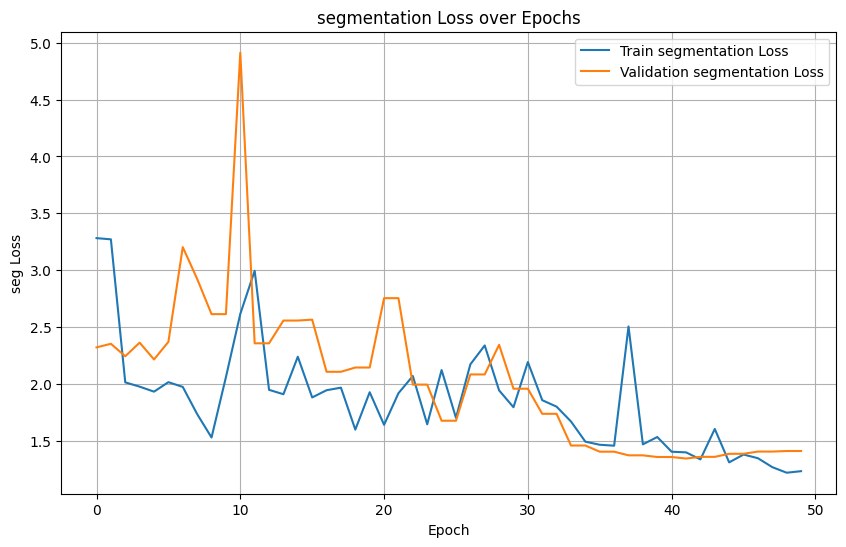

In [ ]:
# Plotting the box loss
plt.figure(figsize=(10, 6))
plt.plot( df['train/seg_loss'], label='Train segmentation Loss')
plt.plot( df['val/seg_loss'], label='Validation segmentation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('seg Loss')
plt.title('segmentation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

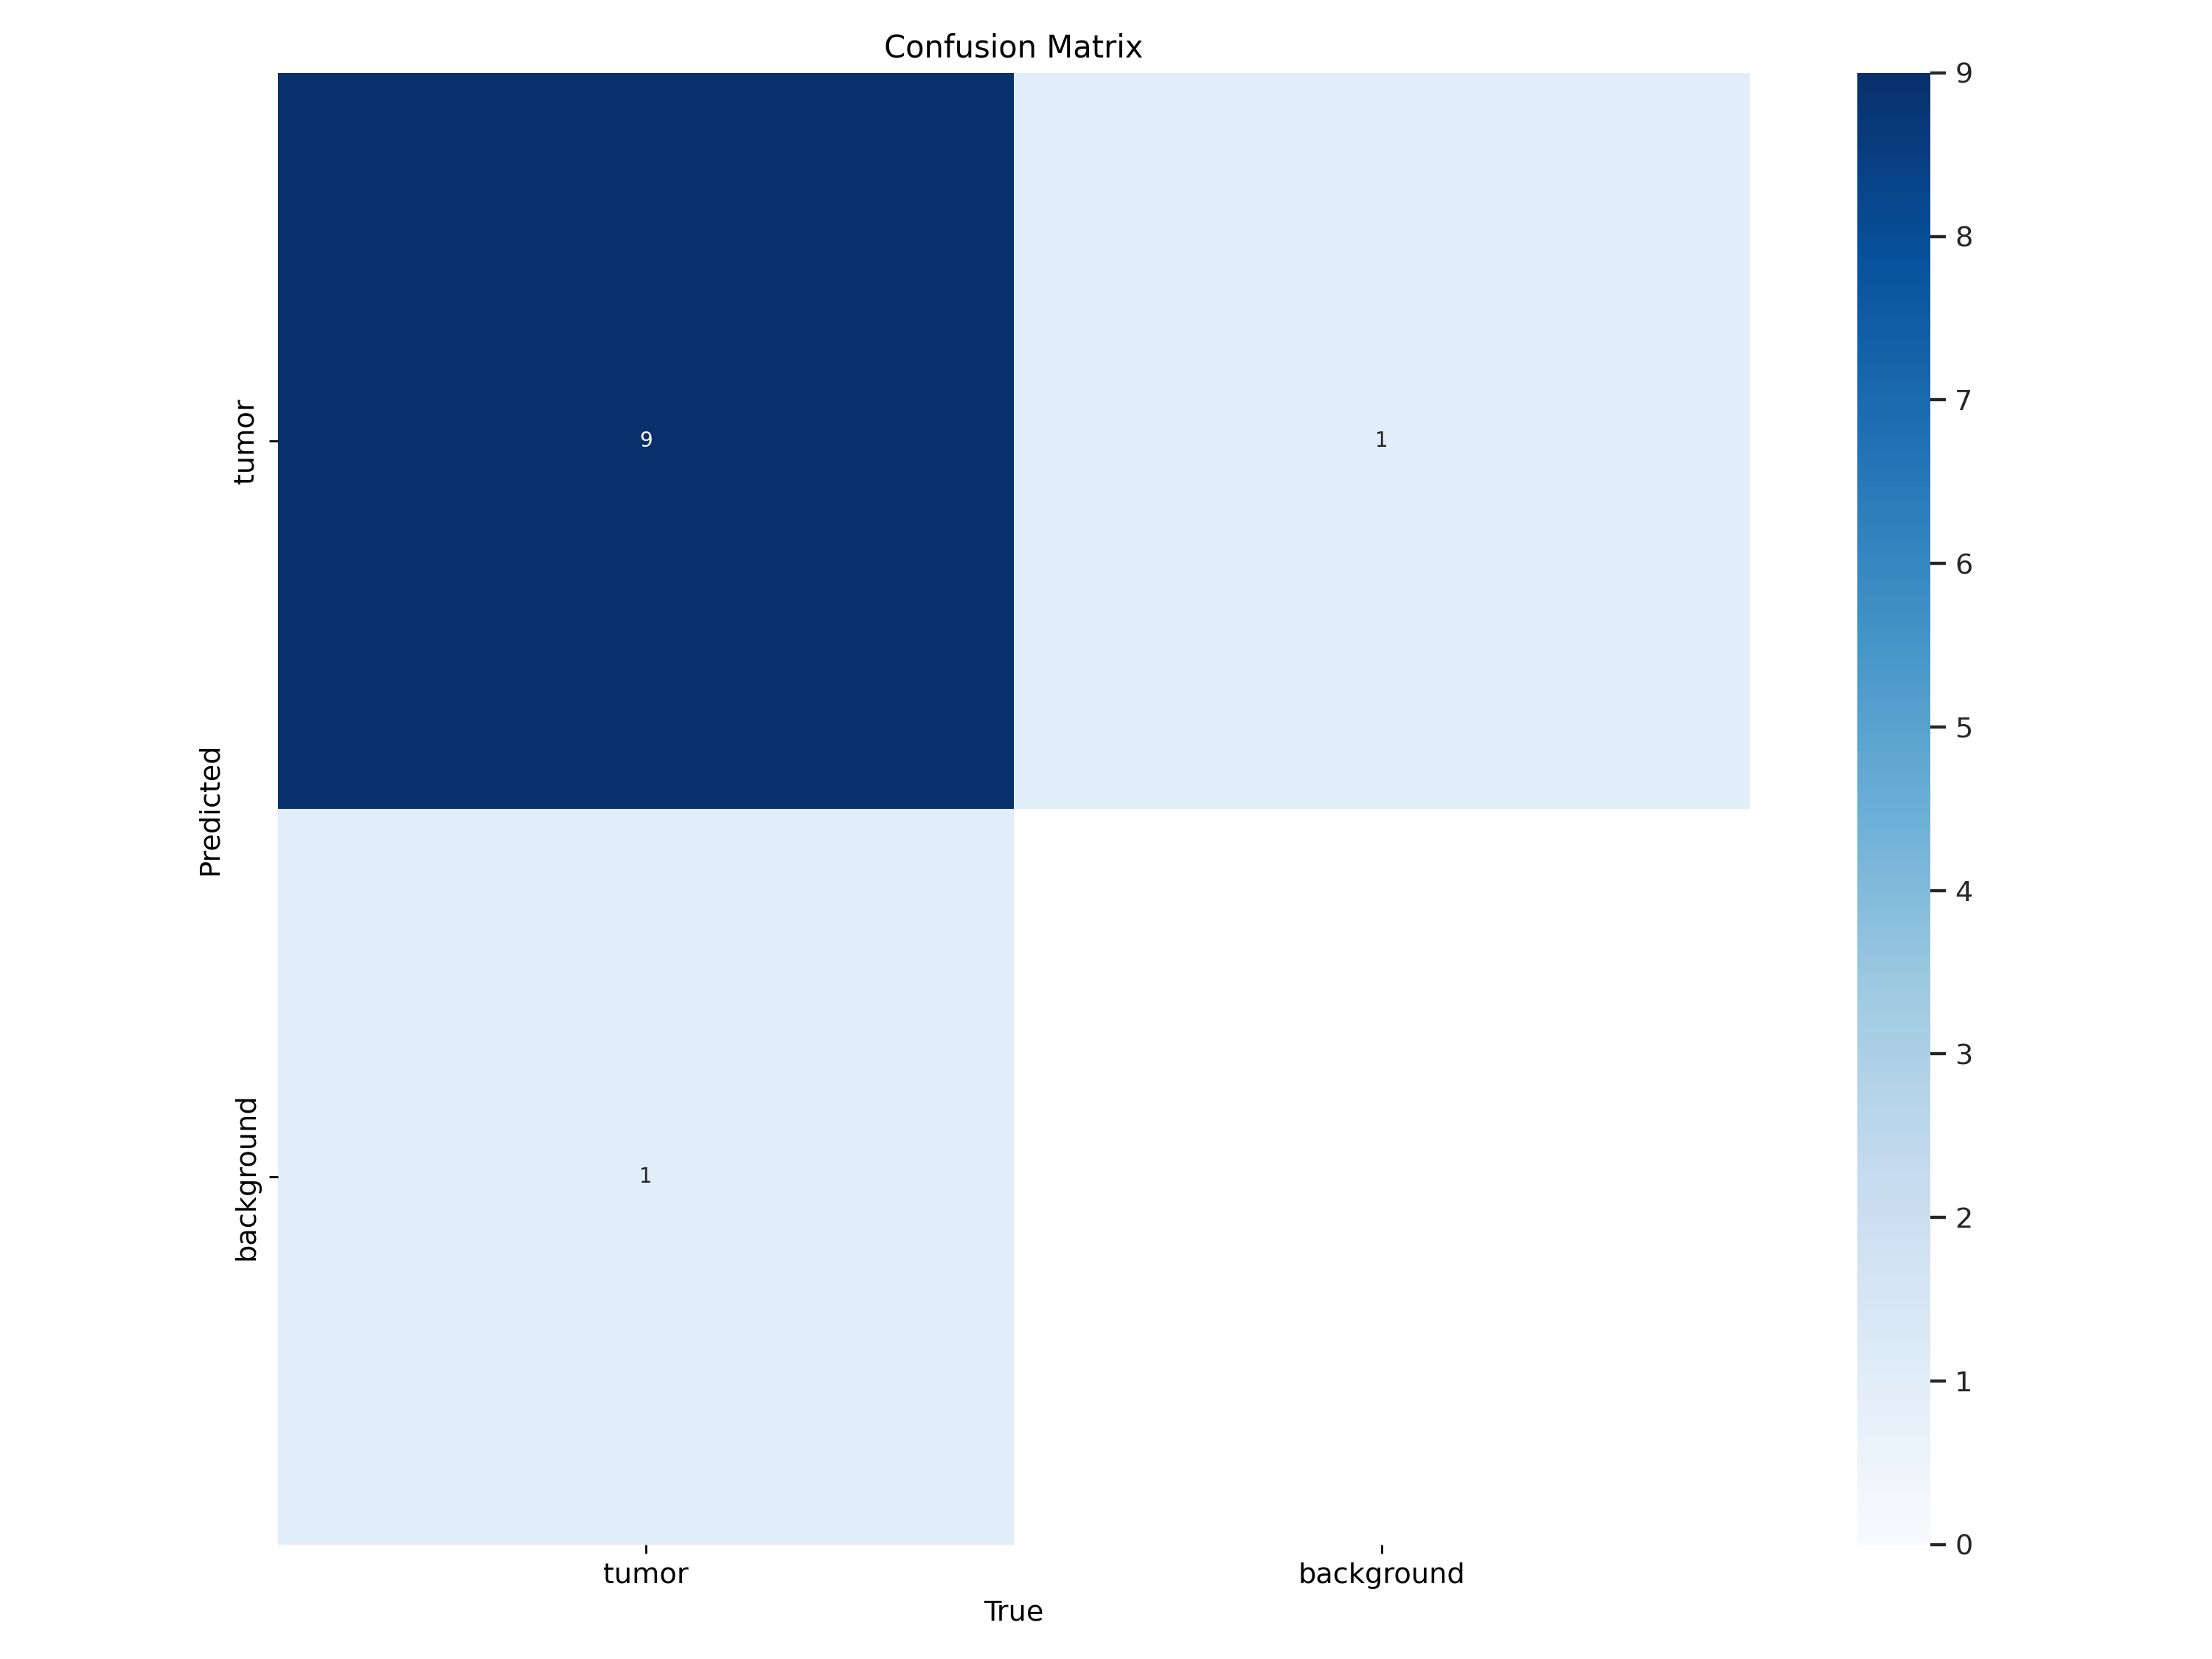

In [ ]:
#Confusion Matrix of training
display(Image(filename="/content/runs/segment/train3/confusion_matrix.png", height=600))

#Save Model

In [ ]:

source_file_path = "/content/runs/segment/train3/weights/best.pt"
destination_directory = "/content/drive/MyDrive/Segmentation/"
destination_path = os.path.join(destination_directory, "best.pt")
# Create the destination directory if it doesn't exist
os.makedirs(destination_directory, exist_ok=True)
# Copy the file
shutil.copy(source_file_path, destination_path)

'/content/drive/MyDrive/Segmentation/best.pt'

# Prediction

In [ ]:
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!yolo task=segment mode=predict model=/content/drive/MyDrive/Segmentation/best.pt conf=0.7 source = /content/Brain-1/valid/images/Tr-me_0024_jpg.rf.7562a1ba6b4a2eb080ecd870da958df1.jpg  save=true

Ultralytics YOLOv8.0.212 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs

image 1/1 /content/Brain-1/valid/images/Tr-me_0024_jpg.rf.7562a1ba6b4a2eb080ecd870da958df1.jpg: 640x640 1 tumor, 10.4ms
Speed: 2.4ms preprocess, 10.4ms inference, 141.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


# Predict on image from internet

In [ ]:
# Download an image from  for test
torch.hub.download_url_to_file('https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/MRI_of_brain_with_sub-ependymal_giant_cell_astrocytoma.jpg/220px-MRI_of_brain_with_sub-ependymal_giant_cell_astrocytoma.jpg', 'tumor.jpg')

100%|██████████| 20.0k/20.0k [00:00<00:00, 10.3MB/s]


In [ ]:

model = YOLO("/content/drive/MyDrive/Segmentation/best.pt")
# from PIL
im1 = Image.open("/content/tumor.jpg")
results1 = model.predict(source=im1,conf=0.7,save=True)  # save plotted images
# from list of PIL/ndarray
results = model.predict(source=[im1])


0: 640x512 1 tumor, 35.2ms
Speed: 2.2ms preprocess, 35.2ms inference, 16.7ms postprocess per image at shape (1, 3, 640, 512)
Results saved to runs/segment/predict5

0: 640x512 3 tumors, 26.9ms
Speed: 12.4ms preprocess, 26.9ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 512)


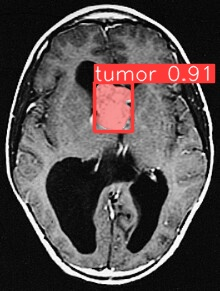

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/runs/segment/predict5/tumor.jpg')[:3]:
      display(Image(filename=image_path, height=600))
      print("\n")